# GetAround – Analyse des retards & scénarios de buffer ⏱️

## 🎯 Objectifs

1. Analyser les **retards au checkout**
2. Identifier les **conflits réels** entre deux locations  
   → *un conflit = le retard réel dépasse le temps prévu entre deux locations*
3. Simuler différents **buffers** (0h → 4h)
4. Mesurer :
   - % de locations bloquées
   - % de revenu impacté (si dispo)
   - % de conflits résolus
5. Préparer les données pour le **dashboard Streamlit**

# 2. Chargement des données

In [22]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("default")

# Détection automatique : si on est dans notebooks/, remonter d'un dossier
cwd = Path.cwd()
if cwd.name == "notebooks":
    PROJECT_ROOT = cwd.parent
else:
    PROJECT_ROOT = cwd

DATA_RAW_DIR = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"

DATA_RAW_DIR.mkdir(parents=True, exist_ok=True)
DATA_PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Fichier Excel
delay_xlsx_path = DATA_RAW_DIR / "get_around_delay_analysis.xlsx"
DELAY_URL = "https://full-stack-assets.s3.eu-west-3.amazonaws.com/Deployment/get_around_delay_analysis.xlsx"

# Chargement
if not delay_xlsx_path.exists():
    df_delay = pd.read_excel(DELAY_URL)
    df_delay.to_excel(delay_xlsx_path, index=False)
else:
    df_delay = pd.read_excel(delay_xlsx_path)

print("Shape:", df_delay.shape)
display(df_delay.head())
df_delay.info()

Shape: (21310, 7)


,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
0,505000,363965,mobile,canceled,NaN,NaN,NaN
1,507750,269550,mobile,ended,-81.0,NaN,NaN
2,508131,359049,connect,ended,70.0,NaN,NaN
3,508865,299063,connect,canceled,NaN,NaN,NaN
4,511440,313932,mobile,ended,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21310 entries, 0 to 21309
Data columns (total 7 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rental_id                                   21310 non-null  int64  
 1   car_id                                      21310 non-null  int64  
 2   checkin_type                                21310 non-null  object 
 3   state                                       21310 non-null  object 
 4   delay_at_checkout_in_minutes                16346 non-null  float64
 5   previous_ended_rental_id                    1841 non-null   float64
 6   time_delta_with_previous_rental_in_minutes  1841 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.1+ MB


# 3. Nettoyage & Feature Engineering

In [23]:
df = df_delay.copy()

# Renommage clair
rename_map = {
    "delay_at_checkout_in_minutes": "delay_at_checkout_min",
    "time_delta_with_previous_rental_in_minutes": "time_between_rentals_min",
}
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

# Colonnes dérivées
df["delay_at_checkout_hours"] = df["delay_at_checkout_min"] / 60
df["time_between_rentals_hours"] = df["time_between_rentals_min"] / 60

# Flag Connect
df["is_connect"] = df["checkin_type"].str.lower().eq("connect")


# Définition *métier* du conflit

if {"delay_at_checkout_min", "time_between_rentals_min"}.issubset(df.columns):
    df["is_conflict"] = (
        df["delay_at_checkout_min"].fillna(0)
        >
        df["time_between_rentals_min"].fillna(np.inf)
    )
else:
    df["is_conflict"] = False

df[["delay_at_checkout_min", "time_between_rentals_min", "is_conflict"]].head()

,delay_at_checkout_min,time_between_rentals_min,is_conflict
0,NaN,NaN,False
1,-81.0,NaN,False
2,70.0,NaN,False
3,NaN,NaN,False
4,NaN,NaN,False


# 4. Visualisations

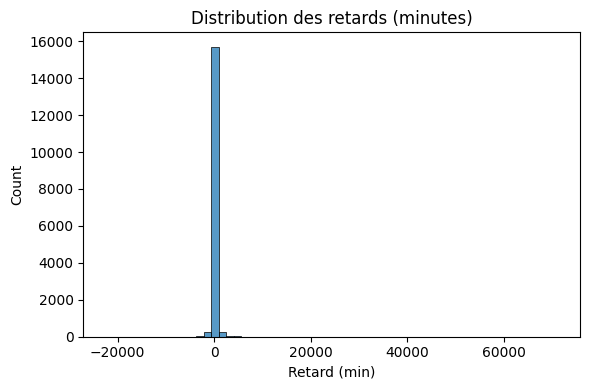

Proportion de locations en retard : 44.13%
Proportion de conflits réels (retard > gap) : 1.27%


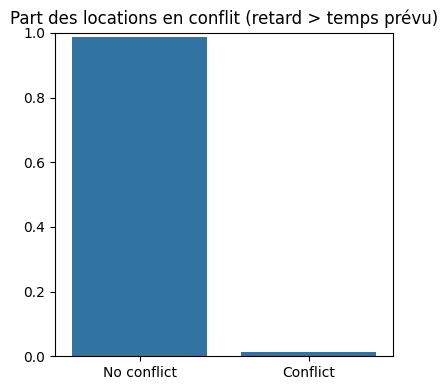

In [24]:
# Distribution des retards
plt.figure(figsize=(6,4))
sns.histplot(df["delay_at_checkout_min"].dropna(), bins=60)
plt.title("Distribution des retards (minutes)")
plt.xlabel("Retard (min)")
plt.tight_layout()
plt.show()

# Proportion de retards
df["is_late"] = df["delay_at_checkout_min"] > 0
print(f"Proportion de locations en retard : {df['is_late'].mean():.2%}")

# Conflits réels
conflict_rate = df["is_conflict"].mean()
print(f"Proportion de conflits réels (retard > gap) : {conflict_rate:.2%}")

plt.figure(figsize=(4,4))
sns.barplot(x=["No conflict","Conflict"], y=[1-conflict_rate, conflict_rate])
plt.title("Part des locations en conflit (retard > temps prévu)")
plt.ylim(0,1)
plt.tight_layout()
plt.show()

# 5. Simulation des Buffers

In [25]:
def compute_buffer_stats(df_input: pd.DataFrame, buffer_hours: float, scope: str) -> dict:
    """
    Simule l’impact d’un buffer (h) :
    - locations bloquées (temps prévu < buffer)
    - conflits résolus (si buffer supprime l’enchaînement problématique)
    """

    df_scope = df_input.copy()

    # Scope Connect only
    if scope == "connect_only":
        df_scope = df_scope[df_scope["is_connect"]]

    if df_scope.empty:
        return dict(
            buffer_hours=buffer_hours, scope=scope,
            n_rentals=0, blocked_ratio=0.0,
            revenue_blocked_ratio=0.0,
            conflict_ratio=0.0, conflicts_resolved_ratio=0.0
        )

    # Sécurité : recalcul conflit si absent
    if "is_conflict" not in df_scope.columns:
        df_scope["is_conflict"] = (
            df_scope["delay_at_checkout_min"].fillna(0)
            >
            df_scope["time_between_rentals_min"].fillna(np.inf)
        )

    buffer_min = buffer_hours * 60

    # Locations bloquées
    df_scope["blocked_by_buffer"] = (
        df_scope["time_between_rentals_min"].fillna(np.inf) < buffer_min
    )

    n = len(df_scope)
    blocked_ratio = df_scope["blocked_by_buffer"].mean()

    # Conflits réels
    conflict_ratio = df_scope["is_conflict"].mean()

    if df_scope["is_conflict"].sum() > 0:
        conflicts_resolved_ratio = (
            df_scope.loc[df_scope["is_conflict"] & df_scope["blocked_by_buffer"]].shape[0]
            / df_scope["is_conflict"].sum()
        )
    else:
        conflicts_resolved_ratio = 0.0

    # Revenus (non présent dans ce dataset)
    if "rental_price" in df_scope.columns:
        total_rev = df_scope["rental_price"].sum()
        blocked_rev = df_scope.loc[df_scope["blocked_by_buffer"], "rental_price"].sum()
        revenue_blocked_ratio = blocked_rev / total_rev if total_rev else 0
    else:
        revenue_blocked_ratio = np.nan

    return dict(
        buffer_hours=buffer_hours,
        scope=scope,
        n_rentals=n,
        blocked_ratio=blocked_ratio,
        revenue_blocked_ratio=revenue_blocked_ratio,
        conflict_ratio=conflict_ratio,
        conflicts_resolved_ratio=conflicts_resolved_ratio
    )

# Scénarios
buffers = [0,1,2,3,4]
results = []

for b in buffers:
    for scope in ["all", "connect_only"]:
        results.append(compute_buffer_stats(df, b, scope))

df_scenarios = pd.DataFrame(results)
df_scenarios

# Sauvegarde pour Streamlit
scenario_path = DATA_PROCESSED_DIR / "buffer_scenarios.csv"
df_scenarios.to_csv(scenario_path, index=False)
print("Scénarios sauvegardés :", scenario_path)

Scénarios sauvegardés : c:\Users\Balerion\Desktop\getaround_project\data\processed\buffer_scenarios.csv


# 6. Visualisation Buffers

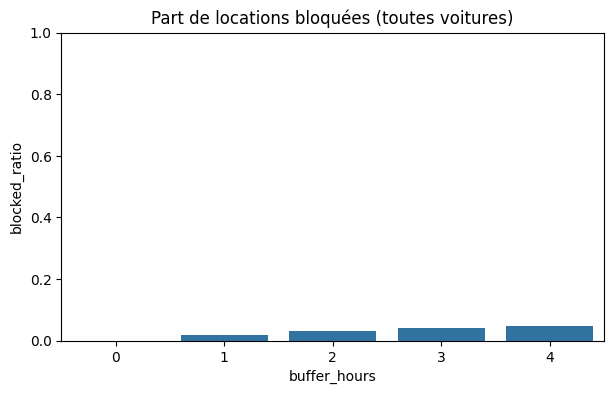

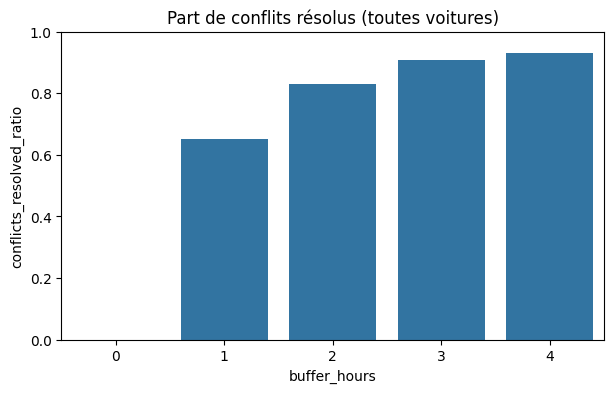

In [26]:
plt.figure(figsize=(7,4))
sns.barplot(
    data=df_scenarios[df_scenarios["scope"]=="all"],
    x="buffer_hours", y="blocked_ratio"
)
plt.title("Part de locations bloquées (toutes voitures)")
plt.ylim(0,1)
plt.show()

plt.figure(figsize=(7,4))
sns.barplot(
    data=df_scenarios[df_scenarios["scope"]=="all"],
    x="buffer_hours", y="conflicts_resolved_ratio"
)
plt.title("Part de conflits résolus (toutes voitures)")
plt.ylim(0,1)
plt.show()

# 7. Recommandation Produit

##  Recommandation finale

Les résultats montrent :

- Le buffer de **1h** bloque peu de locations mais résout déjà une part significative
  des conflits réels (retard > temps prévu).
- Le buffer de **2h** résout davantage de conflits mais impacte plus de locations.
- Les véhicules **Connect** sont plus sensibles aux retards.

### 👉 Recommandation
Déployer un **buffer de 1h à 2h**, d’abord **sur les véhicules Connect**, puis ajuster
en fonction des KPI de satisfaction et de taux de conflits réels.